## Thermal block problem -- data augmentation
**_Keywords: certified reduced basis method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional domain $\Omega$.

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv k_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster evaluation (yet, provably accurate) of the output of interest we propose to use a certified reduced basis approximation for the problem.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$
\begin{cases}
	- \text{div} (\kappa(\mu_0)\nabla u(\boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
	u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}.
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds.$$

The (compliant) output of interest $s(\boldsymbol{\mu})$ given by
$$s(\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class ThermalBlock(EllipticCoerciveCompliantProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ThermalBlock(EllipticCoerciveCompliantProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveCompliantProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "ThermalBlock"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return min(self.compute_theta("a"))

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ThermalBlock class

In [5]:
problem = ThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-10)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(10)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [10]:
"""
Something weird happens when normalization is not identity normalization
"""
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

#def init_weights(m):
#    if isinstance(m, torch.nn.Linear):
#        torch.nn.init.xavier_uniform_(m.weight)
#        m.bias.data.fill_(0.)

#pdnn_net.apply(init_weights)

In [13]:
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
pdnn_trainer.optimizer = optimizer
pdnn_trainer.train()

400 0.005850622730732721 	Loss(validation) = 0.05874103284868159
500 0.000860482150515218 	Loss(validation) = 0.10698728994030132
600 0.00029737649390153433 	Loss(validation) = 0.11052595658399315
700 9.73042589920897e-05 	Loss(validation) = 0.10909840624854869
800 2.7753736356988768e-05 	Loss(validation) = 0.10826616488692255
900 6.861914777901787e-06 	Loss(validation) = 0.10782716909948885
1000 1.4918876278418141e-06 	Loss(validation) = 0.10758881052416573
1100 2.9885218266456996e-07 	Loss(validation) = 0.1074580874232941
1200 6.001027691996389e-08 	Loss(validation) = 0.10738665273622822
1300 1.3088223564684992e-08 	Loss(validation) = 0.10734846639438242
1400 3.0956643872601176e-09 	Loss(validation) = 0.10732824738262739
1500 7.370805373477023e-10 	Loss(validation) = 0.10731766726418011
1600 1.654174151978189e-10 	Loss(validation) = 0.10731232882514666
1700 3.4429253977648947e-11 	Loss(validation) = 0.107309949282766
1800 6.869421810000394e-12 	Loss(validation) = 0.10730867095355476


KeyboardInterrupt: 

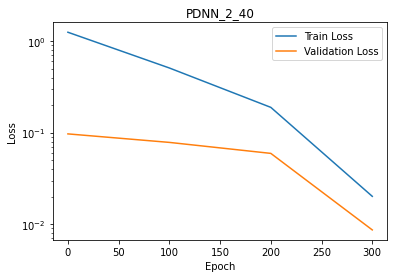

In [11]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

In [ ]:
def dist(v1, v2):
    return torch.norm(v1 - v2)# / torch.sqrt(torch.sum(v1**2))

def replace_predictions_with_labels(snapshots, predictions):
    """
    Estimate a coefficient vector based on snapshots for each 
    predicted coefficient vector.
    """
    
    # fill distance matrix with distances
    distance_matrix = np.zeros((snapshots.shape[1], predictions.shape[1]))
    for i in range(snapshots.shape[1]):
        for j in range(predictions.shape[1]):
            distance_matrix[i, j] = dist(
                snapshots[:, i], predictions[:, j]
            )
    #import matplotlib.pyplot as plt
    #plt.imshow(distance_matrix)
    #plt.colorbar()
    #plt.show()
    
    # estimate new coefficient vector for each prediction
    for j in range(predictions.shape[1]):
        #i = np.argmin(distance_matrix[:, j])
        #predictions[:, j] = snapshots[:, i]
        
        #weights = np.exp(-distance_matrix[:, j]**2)
        #weights /= np.sum(weights)
        
        #weights = np.exp(-distance_matrix[:, j]**3.5)
        #weights /= np.sum(weights)
        
        weights = 1/distance_matrix[:, j]**0.25
        weights /= np.sum(weights)
        
        #weights = 1/(distance_matrix[:, j]+1)
        #weights /= np.sum(weights)
        
        coefficient = 0
        for i in range(distance_matrix.shape[0]):
            coefficient += weights[i] * snapshots[:, i]
        predictions[:, j] = coefficient
    
    return distance_matrix

In [ ]:
pdnn_net.eval()

no_replacements = []
with_replacements = []

with torch.no_grad():
    # get n new parameters for training
    n = 1000
    new_parameters = pdnn_net.augment_parameters_with_time(
        RONNData.get_new_parameters(pdnn_net, n)
    )
    
    # get predicted basis coefficients for these parameters
    predictions = pdnn_net(input_normalization_pdnn(new_parameters)).T
    
    
    for i, mu in enumerate(new_parameters):
        reduced_problem.set_mu(tuple(np.array(mu)))
        reduced_problem.solve()
        solution = np.array(reduced_problem._solution.vector()[:])
        no_replacements.append(np.linalg.norm(
            output_normalization_pdnn(predictions, normalize=False)[:, i].numpy() - solution
        ))
    #    #predictions[:, i] = torch.tensor(solution)
    
    # replace predictions with labels based on distance to original labels
    dm = replace_predictions_with_labels(
        pdnn_loss.proj_snapshots, predictions
    )
    
    predictions2 = pdnn_net(input_normalization_pdnn(new_parameters)).T
    for i, mu in enumerate(new_parameters):
        print(
            np.linalg.norm(
                output_normalization_pdnn(predictions, normalize=False)[:, i].numpy()\
                - output_normalization_pdnn(predictions2, normalize=False)[:, i].numpy()
            )
        )
    
    #print("\n\n\nREPLACED!!!!!!!\n\n\n")
    
    for i, mu in enumerate(new_parameters):
        reduced_problem.set_mu(tuple(np.array(mu)))
        reduced_problem.solve()
        solution = np.array(reduced_problem._solution.vector()[:])
        with_replacements.append(np.linalg.norm(
            output_normalization_pdnn(predictions, normalize=False)[:, i].numpy() - solution
        ))
    
    #for i in range(len(no_replacements)):
    #    print(tuple(new_parameters[i].numpy()), no_replacements[i], with_replacements[i])

        
import matplotlib.pyplot as plt
dif = np.array(with_replacements) - np.array(no_replacements)
plt.scatter(np.array(no_replacements), dif)
plt.plot([0, 10], 
         [0, 0], color='r')
#plt.yscale("log")
plt.xscale("log")
plt.show()
print(np.sum(dif >= 0), np.sum(dif <= 0), np.sum(dif >= 0)/len(dif))
_ = """
    # concatenate new train data to old train data
    data.train_data = torch.cat([data.train_data, new_parameters])

    # update loss function with new labels for training
    pdnn_loss.concatenate_snapshots(predictions)

# switch from eval mode to train mode
pdnn_net.train()

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)

print(pdnn_net.layers[0].weight)
pdnn_net.apply(init_weights)
print(pdnn_net.layers[0].weight)
"""

In [ ]:
# train
pdnn_trainer.num_epochs = 10000
pdnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

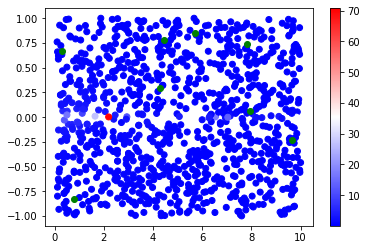

In [14]:
n = 1000
new_parameters = pdnn_net.augment_parameters_with_time(
    RONNData.get_new_parameters(pdnn_net, n)
)
_ = ErrorAnalysis.plot_error(pdnn_net, data, new_parameters, input_normalization_pdnn, output_normalization_pdnn)

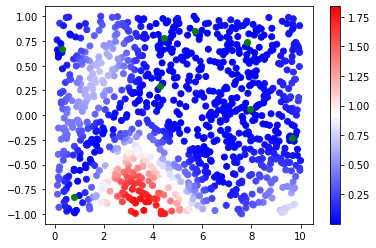

In [15]:
_ = ErrorAnalysis.plot_residual(pdnn_net, data, new_parameters, input_normalization_pdnn, output_normalization_pdnn)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data.train_data[:, 0], data.train_data[:, 1])

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

#### 4.6.2 PDNN Error Analysis

In [ ]:
test_mu = torch.tensor(reduction_method.testing_set)

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (8.0, -1.0), input_normalization_pdnn, output_normalization_pdnn, colorbar=True
)